# Autoencoders with keras-core using the torch backend

This notebook illustrates the usage of [keras-core](https://keras.io/keras_core/guides/getting_started_with_keras_core/) with torch with an example of a small yet efficient autoencoder on the MNIST dataset.

It was originally run on a laptop with:
- Intel(R) Core(TM) i7-1165G7 @ 2.80GHz
- 16GB of RAM
- No discrete GPU

## Prepare the environment

Note the environment variable being set to "torch", the default is "tensorflow". At the moment keras-core (see docs) requires the tensorflow package even if we are using other backends.

In [19]:
import os

os.environ["KERAS_BACKEND"] = "torch"

import logging
import sys
logging.basicConfig(stream=sys.stdout, level=logging.ERROR)
logging.getLogger().addHandler(logging.StreamHandler(stream=sys.stdout))

import matplotlib.pyplot as plt
import numpy as np
import keras_core as keras
from keras_core import layers
from keras_core import ops
from keras_core import regularizers

ENCODER_MODEL_FILE = "../model/encoder.keras"
DECODER_MODEL_FILE = "../model/decoder.keras"

input_dim = 28

## Load MNIST dataset 
Use the first 5000 images from the test set for training evaluation and the last 5000 for post-training validation

In [3]:
with np.load("../dataset/mnist.npz") as f:
    x_train, y_train = f['x_train'], f['y_train']
    x_origtest, y_test = f['x_test'], f['y_test']

x_train = x_train.astype('float32') / 255.
x_test = x_origtest[0:4999].astype('float32') / 255.
x_validation = x_origtest[5000:10000].astype('float32') / 255.

print (x_train.shape)
print (x_test.shape)
print (x_validation.shape)

(60000, 28, 28)
(4999, 28, 28)
(5000, 28, 28)


## Create the model

The architecture is very simple and combines a convolutional layer with a small regularized dense layer, with posterior decoding.

In [11]:
input_layer = layers.Input(shape=(input_dim,input_dim,1), name="input")

encoder = keras.Sequential(
    [         
        input_layer,                    
        layers.Conv2D(8, (4, 4), activation='leaky_relu', padding='same'),              
        layers.MaxPooling2D((2,2)),                        
        layers.Dense(8, use_bias=True, activation='leaky_relu', activity_regularizer=regularizers.L1(10e-3), bias_regularizer=regularizers.L1(10e-3)),
        layers.Dense(16, use_bias=True, activation='leaky_relu', activity_regularizer=regularizers.L1(10e-3), bias_regularizer=regularizers.L1(10e-3)),
        layers.Dense(2, use_bias=True, activation='leaky_relu', activity_regularizer=regularizers.L1(10e-3), bias_regularizer=regularizers.L1(10e-3)),
    ], name="encoder"
)

decoder = keras.Sequential(    [
        layers.UpSampling2D((2,2)),
        layers.Dense(20, use_bias=True, activation='leaky_relu', activity_regularizer=regularizers.L1(10e-3), bias_regularizer=regularizers.L1(10e-3)),
        layers.Dense(10, use_bias=True, activation='leaky_relu', activity_regularizer=regularizers.L1(10e-3), bias_regularizer=regularizers.L1(10e-3)),
        layers.Conv2D(1, (4, 4), activation='sigmoid', padding='same')
    ], name="decoder"
)

model = keras.Sequential(
    [
        input_layer, 
        encoder,
        decoder
    ]
)

model.summary()

Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape              ┃    Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━┩
│ encoder (Sequential)            │ (None, 14, 14, 2)         │        386 │
├─────────────────────────────────┼───────────────────────────┼────────────┤
│ decoder (Sequential)            │ (None, 28, 28, 1)         │        431 │
└─────────────────────────────────┴───────────────────────────┴────────────┘

 Total params: 817 (3.19 KB)

 Trainable params: 817 (3.19 KB)

 Non-trainable params: 0 (0.00 B)

## Compile and execute the model
We use Huber as a loss since it combines MSE and MAE depending on the delta value, and we want the lower the error for the reconstruction.

In [12]:
model.compile(optimizer="adamW", loss=keras.losses.Huber(
    delta=1.0, reduction="sum_over_batch_size", name="huber_loss")
)

trainhist = model.fit(x_train, x_train,
                epochs=10,
                batch_size=256,
                shuffle=True,
                validation_data=(x_test, x_test))

Epoch 1/10
235/235 ━━━━━━━━━━━━━━━━━━━━ 21s 87ms/step - loss: 0.0725 - val_loss: 0.0078
Epoch 2/10
235/235 ━━━━━━━━━━━━━━━━━━━━ 20s 86ms/step - loss: 0.0056 - val_loss: 0.0024
Epoch 3/10
235/235 ━━━━━━━━━━━━━━━━━━━━ 20s 84ms/step - loss: 0.0020 - val_loss: 0.0016
Epoch 4/10
235/235 ━━━━━━━━━━━━━━━━━━━━ 21s 90ms/step - loss: 0.0015 - val_loss: 0.0013
Epoch 5/10
235/235 ━━━━━━━━━━━━━━━━━━━━ 20s 86ms/step - loss: 0.0012 - val_loss: 0.0010
Epoch 6/10
235/235 ━━━━━━━━━━━━━━━━━━━━ 21s 87ms/step - loss: 9.7710e-04 - val_loss: 8.7138e-04
Epoch 7/10
235/235 ━━━━━━━━━━━━━━━━━━━━ 21s 87ms/step - loss: 8.4392e-04 - val_loss: 7.9868e-04
Epoch 8/10
235/235 ━━━━━━━━━━━━━━━━━━━━ 20s 86ms/step - loss: 7.8556e-04 - val_loss: 7.6185e-04
Epoch 9/10
235/235 ━━━━━━━━━━━━━━━━━━━━ 21s 87ms/step - loss: 7.5015e-04 - val_loss: 7.3561e-04
Epoch 10/10
235/235 ━━━━━━━━━━━━━━━━━━━━ 21s 88ms/step - loss: 7.2313e-04 - val_loss: 7.0769e-04


In [13]:
keras.saving.save_model(encoder, ENCODER_MODEL_FILE)
keras.saving.save_model(decoder, DECODER_MODEL_FILE)

In [14]:
encoder = keras.saving.load_model(ENCODER_MODEL_FILE)
decoder = keras.saving.load_model(DECODER_MODEL_FILE)

## Compute the latent representation from the encoder and the reconstruction after using the decoder

In [15]:

latent = encoder.predict(x_validation)
reconstructions = decoder.predict(latent)

157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


## Compute the MSE between each instance of the validation data and its reconstruction

In [16]:

n = 10
error = np.mean(np.square(np.subtract(reconstructions.reshape([5000,input_dim*input_dim]), x_validation.reshape([5000,input_dim*input_dim]))),axis=1)
indices = error.argsort()
worst = indices[indices.shape[0]-n:indices.shape[0]]
best = indices[0:n]


## Bottom 10 Worst reconstructions with their original

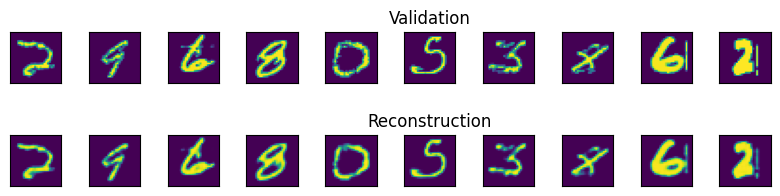

In [17]:

fig, axs = plt.subplots(2,n, figsize=(n,2))
_ = plt.subplots_adjust(hspace = 1)
for i in range(n):
    val_plt = axs[0,i]
    recon_plt = axs[1,i]

    val_plt.get_xaxis().set_visible(False)
    val_plt.get_yaxis().set_visible(False)
    
    recon_plt.get_xaxis().set_visible(False)
    recon_plt.get_yaxis().set_visible(False)
    
    val_plt.imshow(x_validation[worst[i]].reshape(input_dim, input_dim))       
    recon_plt.imshow(reconstructions[worst[i]].reshape(input_dim, input_dim))

_ = axs[0,5].set_title("Validation")
_ = axs[1,5].set_title("Reconstruction")


## Top 10 Best reconstructions with their original (which are all ones)

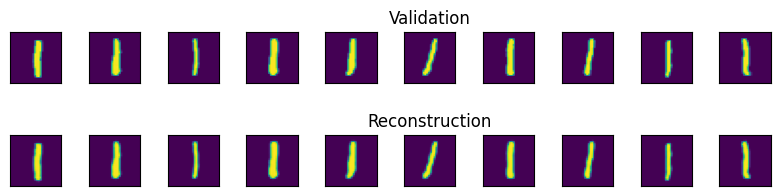

In [18]:
fig, axs = plt.subplots(2,n, figsize=(n,2))
_ = plt.subplots_adjust(hspace = 1)
for i in range(n):
    val_plt = axs[0,i]
    recon_plt = axs[1,i]

    val_plt.get_xaxis().set_visible(False)
    val_plt.get_yaxis().set_visible(False)
    
    recon_plt.get_xaxis().set_visible(False)
    recon_plt.get_yaxis().set_visible(False)
    
    val_plt.imshow(x_validation[best[i]].reshape(input_dim, input_dim))       
    recon_plt.imshow(reconstructions[best[i]].reshape(input_dim, input_dim))

_ = axs[0,5].set_title("Validation")
_ = axs[1,5].set_title("Reconstruction")